# Training the Score Function Estimator


In [21]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

from score_po.score_matching import ScoreEstimator
from score_po.nn import MLP, AdamOptimizerParams, TrainParams

from environment import Environment, plot_samples_and_enviroment

First, let's make a custom environment that we can use to draw data from. We will visualize the drawn points as well. 

Note here that we've normalized all our points to be in between -0.5 and 0.5. 
Empirically neural nets don't perform so well without this normalization.

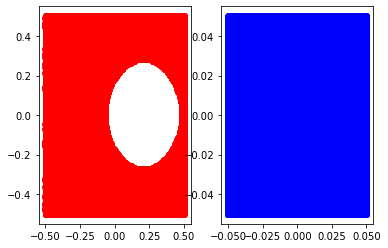

In [22]:
env = Environment()
env.generate_ellipse(24, 24, [90, 64])
pts = env.sample_points(500000) / 128 - 0.5
vel_pts = 1e-1 * (torch.rand(pts.shape[0], 2) - 0.5)
data = torch.hstack((pts, vel_pts))


plt.figure()
plt.subplot(1,2,1)
plt.plot(data[:, 0], data[:, 1], "ro")
plt.subplot(1,2,2)
plt.plot(data[:,2], data[:,3], "bo")
plt.show()

Now we will train a noise-conditioned score function estimator to try to estimate the gradient of this distribution, $s_\theta(z) = \nabla_z \log p(z)$. In order to do that we will need to define a neural network, a dataset object, and a scheduling of the variances.

First, the dataset and the NN can be defined using the following syntax.

In [23]:
dataset = torch.utils.data.TensorDataset(data)

print(data.shape)

# Note that input is 5 because we need to include the parameter corresponding to network.
# The parameter values are taken from typical PPO network.
network = MLP(5, 4, [128, 128])

torch.Size([376016, 4])


Then, we can define a score function estimator and use it to train the network. When we're done, we'll save the weights.

100%|██████████| 2000/2000 [00:15<00:00, 127.03it/s]


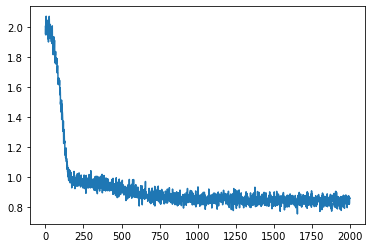

In [24]:
params = TrainParams()
params.adam_params.batch_size = 1024
params.adam_params.epochs = 2000
params.adam_params.lr = 1e-3

sf = ScoreEstimator(network, 2, 2)
loss_lst = sf.train_network(dataset, params, 
                            sigma_max=1e-1, sigma_min=1e-1, n_sigmas=1)

plt.figure()
plt.plot(loss_lst)
plt.show()

sf.save_network_parameters("nn_weights_ds.pth")


We can define a new instance and load the weights again to illustrate how to load files.

In [25]:
sf = ScoreFunctionEstimator(network, 2, 2)
sf.load_network_parameters("nn_weights_ds.pth")

Now let's plot the gradients to see how we did! 

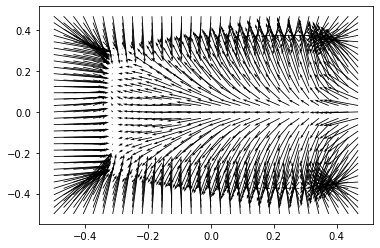

In [26]:
X, Y = np.meshgrid(range(32), range(32))
pos = np.vstack([X.ravel(), Y.ravel()]).T
pos = torch.Tensor(pos) / 32 - 0.5

grads = sf.get_score_x_given_z(torch.hstack((pos, torch.zeros(pos.shape[0], 2))), 0.1)
grads = grads.detach().numpy()
pos = pos.detach().numpy()

UV = np.swapaxes(grads, 0, 1).reshape(2, 32, 32)

plt.figure()
plt.quiver(X / 32 - 0.5, Y / 32 - 0.5, UV[0, :, :], UV[1, :, :], scale=50.0)
plt.show()
